# 丢弃法

## 从零开始实现

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    #如果 dropout 的值为 1，意味着所有的神经元都要被丢弃，所以直接返回一个与 X 形状相同且所有元素都为 0 的张量
    if dropout == 0:
        return X
    #如果 dropout 的值为 0，意味着没有神经元会被丢弃，所以直接返回输入张量 X 本身。
    mask = (torch.randn(X.shape) > dropout).float()
    #torch.randn(X.shape) 生成一个与 X 形状相同的张量，其中的元素服从标准正态分布（均值为 0，标准差为 1）。
    #torch.randn(X.shape) > dropout 对生成的张量中的每个元素进行比较操作，判断该元素是否大于 dropout 的值，得到一个布尔类型的张量，其中每个元素为 True 或 False。
    #.float() 将布尔类型的张量转换为浮点类型的张量，True 转换为 1，False 转换为 0。
    return mask * X / (1.0 - dropout)

In [7]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  0.,  0.,  0., 14.],
        [ 0., 18.,  0.,  0.,  0.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [17]:
# 定义模型参数、模型
dropout1, dropout2 = 0.2, 0.5
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training = True):
        super(Net, self).__init__() #super(Net, self).__init__() 是标准的调用父类构造函数的方式，Net 是当前类的名称，self 是实例对象本身。
                #这里调用 nn.Module 类的 __init__ 方法，目的是确保 Net 类在初始化时，能够执行 nn.Module 类构造函数中的初始化操作。
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True: # 只有在训练模型时才使用dropout
            H1 = dropout_layer(H1, dropout1) # 在第一个全连接层之后添加一个dropout层
        H2 = self.relu(self.lin2(H1))
        if self.training == True: # 只有在训练模型时才使用dropout
            H2 = dropout_layer(H2, dropout2) # 在第2个全连接层之后添加一个dropout层
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [21]:
## 这是上一章的代码，然而在d2l中似乎没有封装进去，先加载下面代码再运行微调后的代码，可以通过。

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: 
        #len(y_hat.shape) > 1 检查 y_hat 是否为二维数组； 确认 y_hat 的第二维（通常是类别数）大于1，意味着有多个类别
        y_hat = y_hat.argmax(axis = 1)
        # 使用 argmax(axis=1) 找到每一行中最大值的索引，这个索引对应预测的类别。argmax 返回的是每行最大值的列索引，即预测的类别标签。
    cmp = y_hat.type(y.dtype) == y #逐元素比较预测类别与真实类别，生成一个布尔数组。由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。
    return float(cmp.type(y.dtype).sum())  # 结果是一个包含0（错）和1（对）的张量。
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2) #初始化为包含两个元素的列表 [0.0, 0.0]。这两个元素分别用于累加正确预测的数量和总样本数量。
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) #y.numel()：获取当前批次的样本数量。
        #metric.add(...)：将当前批次的准确率和样本数量累加到 metric 中
    return metric[0] / metric[1]  #将累加的正确预测数量除以总样本数量，得到整个数据集的平均准确率
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n #初始化一个包含 n 个 0.0 的列表，用于存储累积的值
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] #对每一对 (a, b)，将 a（累加器中的当前值）和 b（新值）相加，并将结果转换成浮点数。
    def reset(self):
        self.data = [0.0] * len(self.data) #将 self.data 中的所有元素重置为 0.0，以便重新开始累积
    def __getitem__(self, idx):
        return self.data[idx] #允许使用索引访问 Accumulator 中的特定元素，例如 metric[0] 访问第一个累积值。

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):  
        net.train()  #net.train() 将模型设置为训练模式
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            # 在训练神经网络时，需要通过反向传播计算损失函数对模型参数的梯度，然后使用优化器根据这些梯度更新参数。优化器决定了每次更新的方向和幅度，从而影响模型的收敛速度和最终性能。
            updater.zero_grad()
            l.mean().backward()
            updater.step()
    #如果 updater 是 torch.optim.Optimizer 的实例，使用PyTorch内置的优化器进行梯度清零、反向传播和参数更新。
    #否则，使用自定义的 updater 函数进行反向传播和参数更新。
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())  #累加当前批次的损失总和、正确预测的数量和样本总数。
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])  #用于可视化训练过程，显示每个epoch的训练损失、训练准确率和测试准确率。
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    #断言：确保训练损失和准确率在合理范围内
    assert train_loss < 0.5, train_loss  #用于检查某个条件是否为真，如果条件为假，则抛出 AssertionError 异常
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y) #将真实标签转换为可读的字符串形式
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1)) #计算模型的预测结果并转换为可读的字符串形式。
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)] #生成每个样本的真实标签和预测标签的组合。
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])  #显示前 n 个样本的图像及其真实标签和预测标签

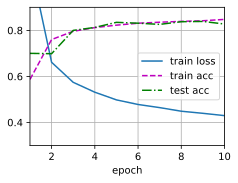

In [25]:
# 训练、测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

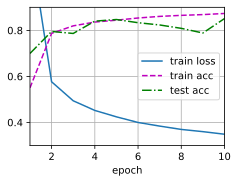

In [27]:
# 简洁实现
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m): #依次对 net 中的每个模块进行处理，并初始化
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)